# Content

This notebook contains:

- Definition and optimization of the geometry of individual_wells() trap.  
- Simulation of ion crystal in this trap.
- Calculation of normal modes in the resulting ion chain

In [1]:
from __future__ import division
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped)
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import warnings
import time
import sion as sn

#puts python plots inline with the code
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Optimization of RF geometry

Here, the geometry of the *sion.individual_wells()* RF trap is optimized for the required set of secular frequencies.

# Initial configuration

This block demonstrates the plot of the initial geometry of the trap, plots of the initial set of secular frequencies in each individual potential well.


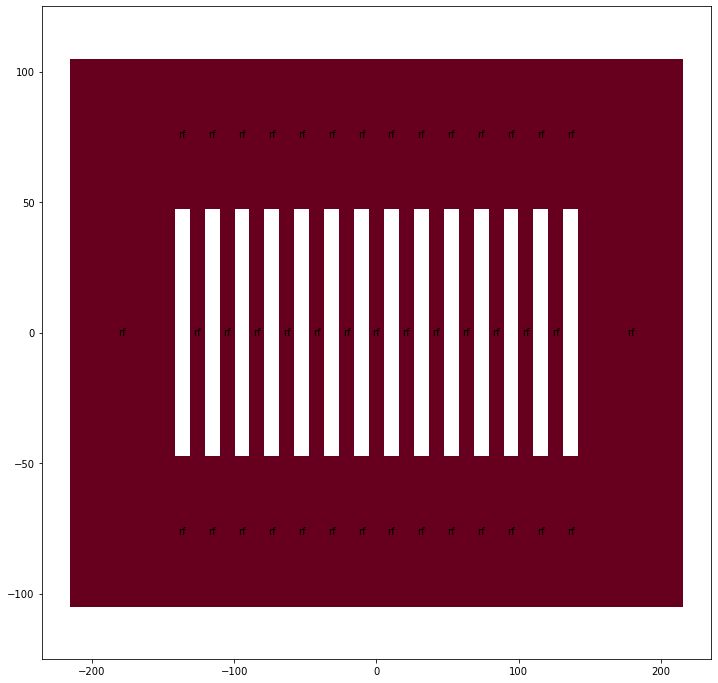

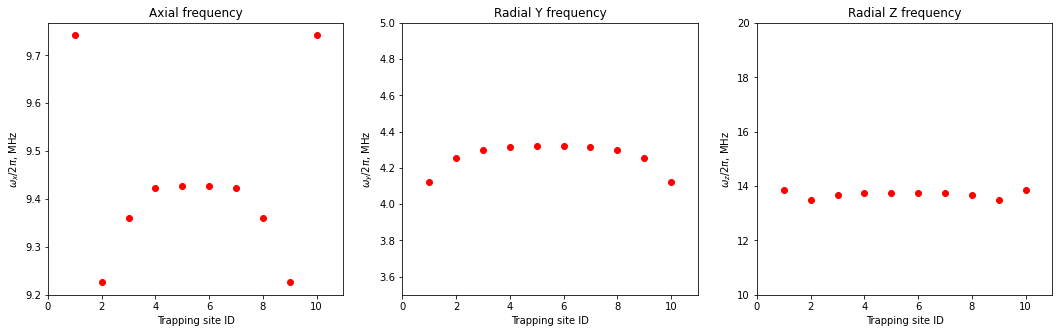

In [2]:
# Global definition of trap parameters. Used for all cells in this notebook
L = 1e-6 # µm length scale
Vrf = 17 #F peak voltage in V
M = 9*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*50e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)
scale = Z/((L*Omega)**2*M)

n_squares = 14
dis = 21
length = (n_squares-1)*dis+7.5*dis
width = 10*dis

#points at which individual wells are produced
dot = [[(-n_squares/2 + 1/2)*dis+i*dis, 0] for i in range(n_squares)]
dot = np.array(dot)

x_start = [dis/2 for i in range(n_squares)]
y_start = [dis*4.5 for i in range(n_squares)]
    
s, coordinates = sn.individual_wells(Urf, width, length, dot, x_start, y_start)

# creates a plot of electrode
fig, ax = plt.subplots(1, 1, figsize = (12,12))
ax.set_xlim(-length/2-20, length/2+20)
ax.set_ylim(-width/2-20, width/2+20)
s.plot_voltages(ax, u=s.rfs)

#determine all frequencies in minimums excluding 2 external traps
freqs_x = []
freqs_y = []
freqs_z = []
positions = []
cutoff = 2
    
for i in range(cutoff, n_squares-cutoff):
    # determine minimum positions 
    x1 = s.minimum(np.array([-(n_squares-1)/2*dis +i*dis , 0, 20.]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    positions.append(x1)
    # determine secular frequencies
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    # modes are sorted accroding the increase of their frequency. In this particular example, y-frequency is lower then x-frequency
    freqs_x.append(omega_sec[1])
    freqs_y.append(omega_sec[0])
    freqs_z.append(omega_sec[2])


fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(range(1,11), freqs_x, 'ro')
ax[0].set_title("Axial frequency")
ax[0].set_ylabel('$\omega_x/2\pi$, MHz')
ax[0].set_xlabel('Trapping site ID')
ax[0].set_xlim(0, 11)

ax[1].plot(range(1,11), freqs_y, 'ro')
ax[1].set_title("Radial Y frequency")
ax[1].set_ylabel('$\omega_y/2\pi$, MHz')
ax[1].set_xlabel('Trapping site ID')
ax[1].set_xlim(0, 11)

ax[2].plot(range(1,11), freqs_z, 'ro')
ax[2].set_title("Radial Z frequency")
ax[2].set_ylabel('$\omega_z/2\pi$, MHz')
ax[2].set_xlabel('Trapping site ID')
ax[2].set_xlim(0, 11)

ax[1].set_ylim(3.5, 5)
ax[2].set_ylim(9, 11)
ax[2].set_ylim(10, 20)

plt.show()


## Optimization procedure

The geometry optimization here determine optimal parameters of width and height of each polygonal notch, used for the individual well preparation. Since these are only two free parameters for each output, we can only optimize 2 of the 3 principle axes simultaneously. 

In this block the geometry is optimized to create the phonon mode configuration, where the full spectrum of an ion crystal is segmented into 5 independent pairs. The optimization is performed only in axial axis.


In [4]:
# determining the desired secular frequency spectrum
axis = [1] #here it  denotes x
# frequency in MHz/2pi
omeg_x = np.array([0.9, 0.9, 0.95, 0.95, 1, 1, 1.05, 1.05, 1.1, 1.1])*9.4
omegas = [omeg_x]

# optimization parameters
learning_rate = 0.1
stoch = 5
eps = 1e-3
step = 100

# executing optimization
start_time = time.time()

# First we will run stochastic descent to its expected convergence, then finish with the gradient descent
x, y = sn.geometry_optimization(Urf, width, length, x_start, y_start, Z, M, dot, positions, axis, omegas, learning_rate, stoch, eps, L, step)

stoch = 0
eps = 1e-8
learning_rate = 0.01
x, y = sn.geometry_optimization(Urf, width, length, x, y, Z, M, dot, positions, axis, omegas, learning_rate, stoch, eps, L, step)

print('Optimization took %s minutes' %(-(start_time-time.time())//60))

Initial loss: 0.06592101830925841
Iteration: 100 Loss function: 0.0004818416585769186
x = [10.475731943652798, 10.719477168966668, 10.61162142016, 10.508323223853361, 10.601628326962853, 10.494748942263731, 10.531851978705099, 10.468997110187782, 10.460088378948036, 10.463709993770793, 10.320062750498803, 10.489763310107373, 10.580339174548314, 10.527537937694776] 
y = [94.3290029787623, 94.32900292923762, 94.3290029050906, 94.32900290061602, 94.32900290603061, 94.32900292250018, 94.3290030036649, 94.67099693121045, 94.6709970717071, 94.67099709187727, 94.670997095944, 94.67099708611721, 94.67099705412869, 94.67099699506234]
Initial loss: 0.0004818416585769186
Iteration: 100 Loss function: 1.8052573004411756e-06
x = [10.357280622873247, 10.695242050007403, 10.660826608464479, 10.448597230240148, 10.627598704491307, 10.482193394685886, 10.513493611993491, 10.510514249293646, 10.398873263529813, 10.531121154755574, 10.251672198132043, 10.52650626283145, 10.640928555379611, 10.57778695415

## Optimized secular frequency set

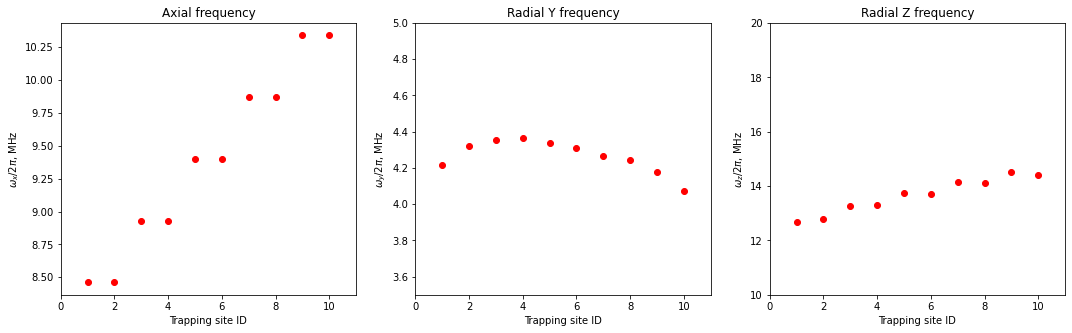

In [5]:
#determine all frequencies in minimums excluding 2 external traps
freqs_x = []
freqs_y = []
freqs_z = []
positions = []
cutoff = 2

x = [10.347630402730395, 10.69281494042719, 10.664176679457011, 10.444690450695338, 10.629072249587399, 10.481855805611382, 10.511893962265914, 10.513261537502496, 10.394873137351013, 10.535559981083681, 10.24690190481848, 10.528969458561344, 10.645056695642873, 10.581143175696402] 
y = [94.31119867476515, 94.33109697232847, 94.33897796107375, 94.33027487215445, 94.38593057056553, 94.27490967870378, 94.34351694949017, 94.64274944465272, 94.65653495776888, 94.64676984287, 94.65411613413578, 94.65068090951388, 94.65122988714025, 94.65550612372606]

s, coordinates = sn.individual_wells(Urf, width, length, dot, x, y)

omegas = []    

for i in range(cutoff, n_squares-cutoff):
    # determine minimum positions 
    x1 = s.minimum(np.array([-(n_squares-1)/2*dis +i*dis , 0, 20.]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    positions.append(np.array([x1[0]+(-1)**i, x1[1], 20])*L)
    # determine secular frequencies
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    # modes are sorted accroding the increase of their frequency. In this particular example, y-frequency is lower then x-frequency
    freqs_x.append(omega_sec[1])
    freqs_y.append(omega_sec[0])
    freqs_z.append(omega_sec[2])
    omegas.append([omega_sec[1]*1e6, omega_sec[0]*1e6, omega_sec[2]*1e6])


fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(range(1,11), freqs_x, 'ro')
ax[0].set_title("Axial frequency")
ax[0].set_ylabel('$\omega_x/2\pi$, MHz')
ax[0].set_xlabel('Trapping site ID')
ax[0].set_xlim(0, 11)

ax[1].plot(range(1,11), freqs_y, 'ro')
ax[1].set_title("Radial Y frequency")
ax[1].set_ylabel('$\omega_y/2\pi$, MHz')
ax[1].set_xlabel('Trapping site ID')
ax[1].set_xlim(0, 11)

ax[2].plot(range(1,11), freqs_z, 'ro')
ax[2].set_title("Radial Z frequency")
ax[2].set_ylabel('$\omega_z/2\pi$, MHz')
ax[2].set_xlabel('Trapping site ID')
ax[2].set_xlim(0, 11)

ax[1].set_ylim(3.5, 5)
ax[2].set_ylim(9, 11)
ax[2].set_ylim(10, 20)

plt.show()

# Simulation of ion motion

In this block the simulation of 10 ions in 10 central individual wells is performed. Simulation is quite slow due to the complexity of geometry.

In [21]:

name = Path('individual_wells_geometry_optimization.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}

u_set = np.ones(3*n_squares + 1 + 1)*Vrf
u_set[-1] = 0
Omegas = [Omega for i in range(3*n_squares+1)]

print(positions)
sim.append(pl.placeions(Caions, positions))

sim.append(sn.polygon_trap(Omegas, u_set, coordinates[0], coordinates[1]))


sim.append(pl.langevinbath(0, 1e-8))

sim.append(pl.dump('posgeom.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(1e4))

sim.execute()

_, data = pl.readdump('posgeom.txt')
data *=1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

[array([-9.03727868e-05,  2.95167890e-21,  2.00000000e-05]), array([-7.43037794e-05, -8.43281655e-23,  2.00000000e-05]), array([-5.10186796e-05, -2.66007129e-23,  2.00000000e-05]), array([-3.28520893e-05,  1.38057842e-22,  2.00000000e-05]), array([-9.59764019e-06,  2.20231071e-24,  2.00000000e-05]), array([ 9.32063411e-06, -2.57007895e-24,  2.00000000e-05]), array([3.20532298e-05, 5.76169714e-24, 2.00000000e-05]), array([5.13227359e-05, 1.40742845e-23, 2.00000000e-05]), array([7.32333591e-05, 2.50319092e-22, 2.00000000e-05]), array([9.20582075e-05, 8.51047970e-23, 2.00000000e-05])]
Reducing timestep to 1.5915494309189535e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Creat

C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Ion trajectory in the trap under strong cooling

<ipython-input-22-44d73e86c1c4>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


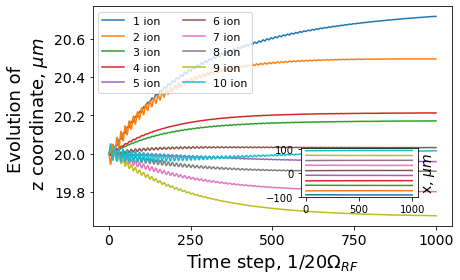

In [22]:
#import data
_, data = pl.readdump('posgeom.txt')
data *=1e6

#plotting routine
fig, ax = plt.subplots(1,1,figsize = [6.5, 4] )
for n in range(n_squares-4):
    st = str(n+1)
    ax.plot(np.arange(100 * 10 + 1), data[0:1001, n, 2], label = st + ' ion')
plt.locator_params(axis='x', nbins=5)
ax.legend(prop = {'size': 11}, ncol = 2)
#ax.set_ylim(19.9, 20.1)
ax.tick_params(axis='both', which='major', labelsize=14)
left, bottom, width, height = [0.65, 0.3, 0.25, 0.17]
ax2 = fig.add_axes([left, bottom, width, height])
for n in range(n_squares-4):
    ax2.plot(np.arange(100 * 10 + 1), data[0:1001, n, 0])
ax2.set_ylabel('x, $\mu m$', fontsize = 14)
ax2.yaxis.set_label_position("right")
ax.set_ylabel('Evolution of \n z coordinate, $\mu m$', fontsize = 18)
ax.set_xlabel('Time step, $1/20\Omega_{RF}$', fontsize = 18)
plt.tight_layout()
plt.show()

# Normal modes

In this block the normal modes of the resulting crystal are calculated. The normal modes interaction matrices, defined as $M_{in} = b_{in}/max(b_{in})$, where $b_{in}$ are the normal mode vector values for mode $n$ and ion $i$. 

On the axial modes interaction matrix we see, that the spectrum is segmented into 5 independent mode segments of ion pairs.

Axial freqs: [4068772. 4165489. 4203951. 4230424. 4257108. 4298287. 4305135. 4325446.
 4338828. 4355316.]
Radial freqs y: [ 8463141.  8479784.  8936057.  8946984.  9406186.  9415441.  9876186.
  9884542. 10343186. 10352464.]
Radial freqs z: [12670651. 12777408. 13276794. 13290757. 13706584. 13736462. 14108082.
 14135640. 14411542. 14513145.]


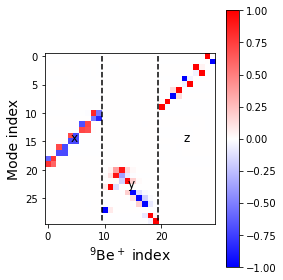

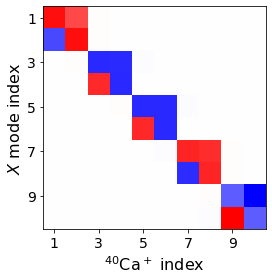

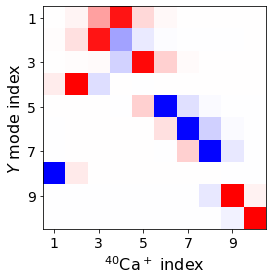

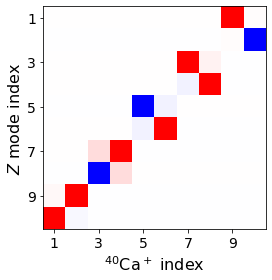

X Normal Vectors:
[0.7960392518590078, 0.6052035422062286, 0.006971845620449294, 0.0012366188557529961, 0.00019276234513791347, 8.598504233334958e-05, 2.9920071076919827e-05, 1.7681438224081594e-05, 8.503166258676327e-06, 5.7991183748277384e-06]
[-0.6052432060407585, 0.7960105734601578, 0.0068572830616774405, 0.000887847296540152, 0.00010540165225360462, 3.920713605470007e-05, 1.184015572032995e-05, 6.282933272702022e-06, 2.776273402742115e-06, 1.7650162706410623e-06]
[0.0013083974253144928, 0.007890689094936787, -0.7090828315008713, -0.705040448813679, -0.007354513207071627, -0.0011813503628022534, -0.0001885614523163507, -8.23573926831989e-05, -2.93174145708774e-05, -1.7414660739613427e-05]
[-0.0006692994730802844, -0.005790942647851426, 0.7050562942818588, -0.7091038988617273, -0.005732268781537848, -0.0006581878479693306, -7.825869308335854e-05, -2.7083675032146087e-05, -8.037602150233334e-06, -4.086289041615187e-06]
[9.030433615100344e-05, 0.00017950745348326198, 0.001097143164814

In [8]:
omegas = np.array(omegas)
    

ion_number = 10
ion_masses = [M for el in range(ion_number)]

_, data = pl.readdump('posgeom.txt')


final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]
sort = np.argsort(final_x)

ion_positions = np.zeros([ion_number, 3])

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

freqs, modes = sn.normal_modes(ion_positions, omegas, ion_masses)

axial_freqs = freqs[0:ion_number]
radial_freqs_y = freqs[ion_number:2*ion_number]
radial_freqs_z = freqs[2*ion_number:3*ion_number]
radial_modes_y = np.zeros([ion_number,ion_number])
radial_modes_z = np.zeros([ion_number,ion_number])
axial_modes = np.zeros([ion_number,ion_number])

for i in range(ion_number):
    for j in range(ion_number):
        axial_modes[i, j] = modes[i+1*ion_number][j+0*ion_number]
for i in range(ion_number):
    for j in range(ion_number):
        radial_modes_z[i, j] = modes[i+2*ion_number][j+2*ion_number]

for i in range(ion_number):
    for j in range(ion_number):
        radial_modes_y[i, j] = modes[i+0*ion_number][j+1*ion_number]

np.set_printoptions(0)
print('Axial freqs:', axial_freqs)
print('Radial freqs y:', radial_freqs_y)
print('Radial freqs z:', radial_freqs_z)


plt.figure(figsize = [4,4])
plt.imshow(modes[::-1,:] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
plt.colorbar()
plt.tight_layout()
plt.vlines([9.5,19.5], ymin = 0, ymax = 29 ,linestyles = 'dashed', color = 'k')
plt.locator_params(axis='x', nbins=3)
plt.text(4, 15,'x', fontsize = 'large')
plt.text(14,23,'y',fontsize = 'large')
plt.text(24, 15,'z',fontsize = 'large')
plt.xlabel('$^{9}$Be$^+$ index', fontsize = 14)
plt.ylabel('Mode index', fontsize = 14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(axial_modes[:] / np.max(np.abs(axial_modes[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$X$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(radial_modes_y[::-1,:] / np.max(np.abs(radial_modes_y[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$Y$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(radial_modes_z[::-1,:] / np.max(np.abs(radial_modes_z[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$Z$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

print('X Normal Vectors:')
for i in range(ion_number):
    print(list(axial_modes[i]))

print('Y Normal Vectors:')
for i in range(ion_number):
    print(list(radial_modes_y[i]))

print('Z Normal Vectors:')
for i in range(ion_number):
    print(list(radial_modes_z[i]))
    